In [2]:
## packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Practical session 3: Disciminant analysis, PCA and classification

Last theory lecture covered:
* LDA
* SVMs

In this notebook we will go over how to implement these models.

## Linear Disciminant analysis (LDA)

In the binary classification setting, we want to predict the probability that an instance belongs to one of two classes, given the data: $p(y|\mathbf{x})$, also called the class posterior. In the previous lab, we saw that logistic regression directly models this probability. Classifiers that directly model the class posterior are called **discriminative classifiers**. Logistic regression is one of the most popular discriminative classification algorithms. 

In contrast, **generative classifiers** first model the probability of the data for each specific class $p(\mathbf{x}|y)$ and then use Bayes' rule to invert that probability to obtain the class posterior:

\begin{equation}
Pr(y=k|\mathbf{x}) = \frac{Pr(\mathbf{x}|y=k)Pr(y=k)}{Pr(\mathbf{x})} = \frac{Pr(\mathbf{x}|y=k)Pr(y=k)}{\sum_{l=1}^{K}Pr(\mathbf{x}|y=l)Pr(y=l)}
\end{equation}

These models are called generative because they specify the class-conditional densities $p(\mathbf{x}|y)$, which allows to generate new observations $\mathbf{x}$ for a class $y$: for a given class $y$, we can sample from the distribution $p(\mathbf{x}|y)$. 

**LDA is an example of a generative classifier.** LDA assumes that the data in each class can be modelled as a multivariate Gaussian distribution. Furthermore, the assumption is made that the (co)variance within and between predictor variables is the same for all the classes. As such, only a limited number of parameters have to be estimated from the data to fully specify the class-conditional distributions: in the multivariate case, we need to estimate the class-specific mean vectors $\mathbf{\mu_{k}}$ and the common covariance matrix $\Sigma$. In the case of just one predictor, this simplifies to estimating the mean of $x$ within each class and the variance $\sigma^2$. The priors $p(y=k)$ are simply estimated from the data by calculating the proportion of training instances in each class. 


To introduce the LDA, we will make use of a simple 1-dimensional toy dataset that contains two classes.

In [3]:
# Read in the data
data = pd.read_csv('toydata_LDA.csv')
type(data)
data.head()

,x,y
0,2.418646,1.0
1,0.485199,1.0
2,0.983165,1.0
3,3.732385,1.0
4,0.291976,1.0


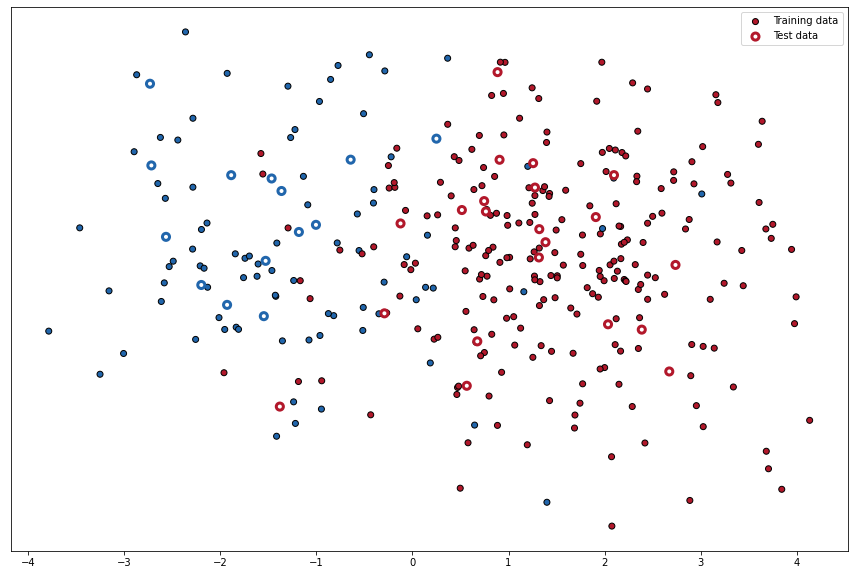

In [4]:
# Split in train/test sets following a 90/10 ratio
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['x'], data['y'], test_size=0.10, random_state=0)

# The code down below will visualize the data and the train-test split
# (The y-axis contains just random scatter as the toy data is 1D)
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(X_train, np.random.normal(scale=0.001,size=len(X_train)),
           color=['#b2182b' if y else '#2166ac' for y in y_train],
          edgecolor='black')
ax.get_yaxis().set_ticks([]);
ax.scatter(X_test, np.random.normal(scale=0.001, size=len(X_test)),
          color='white', edgecolor=['#b2182b' if y else '#2166ac' for y in y_test], linewidth=3, s=50)
ax.legend(['Training data', 'Test data'])

We want to classify the test data in white with LDA. In order to do so, we will need to estimate the prior probabilities of an observation belonging to each class and the class-conditional densities. In LDA, we make a convenient assumption: we model the class-conditional densities with a normal distribution. In that way, we only need to estimate the mean and the variance for each class. Furthermore, we assume that the variance is the same in both classes.

<div class="alert alert-success">
<h3> Exercise </h3>  
<p>
Using the training data, estimate the parameters that are required for LDA. The priors $p(y=k)$ are simply estimated from the data by calculating the proportion of training instances in each class.To estimate the variance, use the following formula (see slide 6 of the theory lectures), where $K$ denotes the number of classes: 
</p>
</div>

![formula](./slide6.png)

<div class="alert alert-block alert-warning">
For reproducibility purposes we will always use random_state=0 in this practical. Don't forget to assign this parameter in your functions if it is needed.
</div>

In [5]:
# estimate the prior probabilities
p_0 = len(X_train[y_train == 0])/len(y_train)
p_1 = len(X_train[y_train == 1])/len(y_train)

# Estimate the mean of both gaussians
mu_0 = np.mean(X_train[y_train == 0])
mu_1 = np.mean(X_train[y_train == 1])

# Estimate the variance sigma²
sigma_sq = ((np.sum((X_train[y_train == 0] - mu_0)**2))+(np.sum((X_train[y_train == 1] - mu_1)**2)))/(len(y_train)- 2)

print('p_0: ' + str(p_0))
print('p_1: ' + str(p_1))
print('mu_0: ' + str(mu_0))
print('mu_1: ' + str(mu_1))
print('sigma_sq: ' + str(sigma_sq)) 

p_0: 0.273015873015873
p_1: 0.726984126984127
mu_0: -1.197017433094278
mu_1: 1.5248635214960005
sigma_sq: 1.473922864862082


<div class="alert alert-success">
<h3>Exercise</h3>
<p>
Now, for each instance $x$ in the test data set, use the parameters above to fill in Bayes' rule and to calculate the probability of that instance to belong to each class. Use scipy.stats.norm.pdf(x, location, scale) to calculate the pdf of the normal distribution. 
</p>
</div>

Classification accuracy: 94.29%


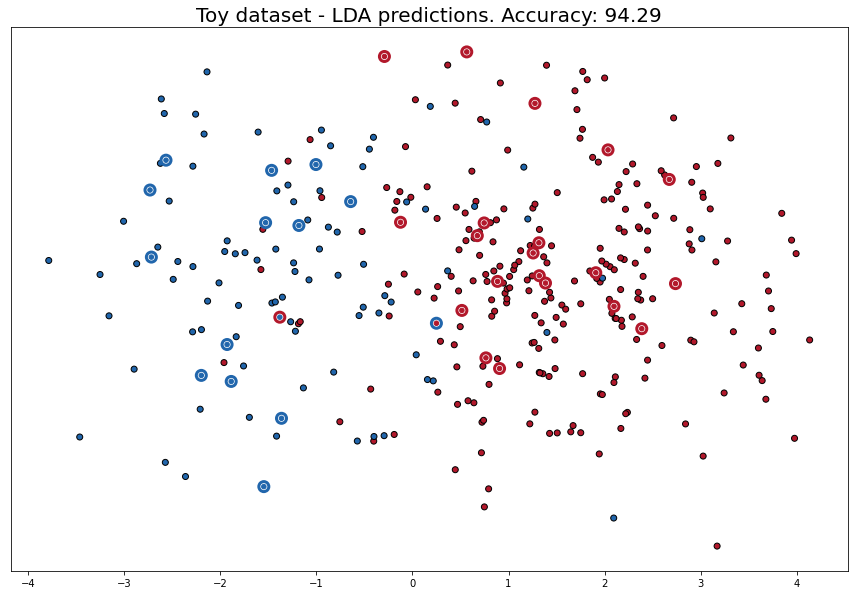

In [6]:
import scipy as sc 

prob_class_0 = []
prob_class_1 = []

for x in X_test:
    likelihood_0 = sc.stats.norm.pdf(x, loc=mu_0, scale=sigma_sq**0.5)
    likelihood_1 = sc.stats.norm.pdf(x, loc=mu_1, scale=sigma_sq**0.5)
    marginal = p_0*likelihood_0 + p_1*likelihood_1
    
    posterior_0 = p_0*likelihood_0/marginal
    posterior_1 = p_1*likelihood_1/marginal
    prob_class_0.append(posterior_0)
    prob_class_1.append(posterior_1)

# ** solution **
predicted_classes = [0 if prob_class_0[i] > prob_class_1[i] else 1 for i in range(len(prob_class_0))]

accuracy = np.round(np.mean(predicted_classes == y_test)*100,2)
print('Classification accuracy: {}%'.format(accuracy))

# Visualize the predictions
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(X_train, np.random.normal(scale=0.001,size=len(X_train)),
           color=['#b2182b' if y else '#2166ac' for y in y_train],
          edgecolor='black')
ax.get_yaxis().set_ticks([]);
test_jitter = np.random.normal(scale=0.001, size=len(X_test))
ax.scatter(X_test, test_jitter,
          color='white', edgecolor=['#b2182b' if y else '#2166ac' for y in y_test], s=100, linewidth=3)
ax.scatter(X_test, test_jitter,
          color=['#b2182b' if y else '#2166ac' for y in predicted_classes], s=20)
ax.set_title('Toy dataset - LDA predictions. Accuracy: {}'.format(accuracy)).set_fontsize(20)


<div class="alert alert-success">
    <h3>Exercise</h3>
        <p>
The two classes from the toy dataset were simulated from two Gaussian distributions with mean -1.5 for class 0 and 1.5 for class 1, and a standard deviation of 1.2. Run the code below to see how well LDA has modelled these distributions. </p>
</div>

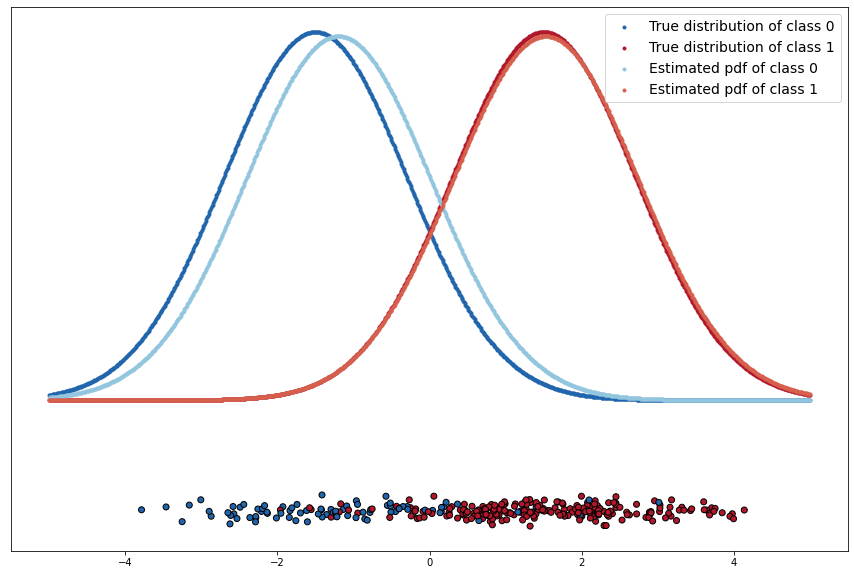

In [7]:
try:
    xrange = np.arange(-5,5,0.01)
    dist_0 = sc.stats.norm.pdf(xrange, loc=-1.5, scale=1.2)
    dist_1 = sc.stats.norm.pdf(xrange, loc=1.5, scale=1.2)
    est_0 = sc.stats.norm.pdf(xrange, loc=mu_0, scale=sigma_sq**0.5)
    est_1 = sc.stats.norm.pdf(xrange, loc=mu_1, scale=sigma_sq**0.5)

    fig, ax = plt.subplots(figsize=(15,10))
    ax.scatter(xrange, dist_0, color='#2166ac', marker='.')
    ax.scatter(xrange, dist_1, color='#b2182b', marker='.')
    ax.scatter(xrange, est_0, color='#92c5de', marker='.')
    ax.scatter(xrange, est_1, color='#d6604d', marker='.')

    # Add the training points 
    ax.scatter(X_train, np.random.normal(loc=-0.1,scale=0.005,size=len(X_train)),
           color=['#b2182b' if y else '#2166ac' for y in y_train],
          edgecolor='black')
    ax.get_yaxis().set_ticks([]);
    ax.legend(['True distribution of class 0',
            'True distribution of class 1', 
            'Estimated pdf of class 0',
            'Estimated pdf of class 1'],
             fontsize=14)
except:
    print('Estimate the parameters of the Gaussians first: mu_0, mu_1, sigma_sq')
    

Obviously, there is no need to always do these calculations yourself. Scikit-learn has an implementation of the LDA.

<div class="alert alert-success">
<h3> Exercise:</h3>
<ol> 
 <li> Use the iris dataset from last lab (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html), load the X and y data in the notebook
 <li> Assess the assumptions the LDA classifier enforces on the predictors with the help of the guide code down below. 
    <ol> 
        <li> For the normality assumption: check the distributions of the predictors with histogram plots and select the predictors that conform to the normality assumption
        <li> For the equal variance assumption: check the variances of the chosen predictors with boxplots (if more than one is chosen) and perform a data transformation if necessary.
    </ol>
 <li> Split the data 80/20 in a train/test set (Note when only one regressor is selected, it should be correctly represented (not as a row but as a column vector. Use .values.reshape(-1,1) to fix this issue)
 <li> Construct the LDA classifier
 <li> Fit the classifier, predict the test labels and calculate the accuracy score of the prediction task
 </ol>
</div>

guide-code:
```
fig, axes = plt.subplots(2, 2)
sns.histplot(predictor1, kde = True, color="skyblue", ax = axes[0,0])
sns.histplot(predictor2, kde = True, color="skyblue", ax = axes[0,1])
...


sns.boxplot(data, color="skyblue", ax = axes[0,0])
```


In [8]:
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# Load in data
iris_X, iris_y = datasets.load_iris(return_X_y = True, as_frame = True)

# Inspect data
iris_X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


<AxesSubplot:xlabel='petal width (cm)', ylabel='Count'>

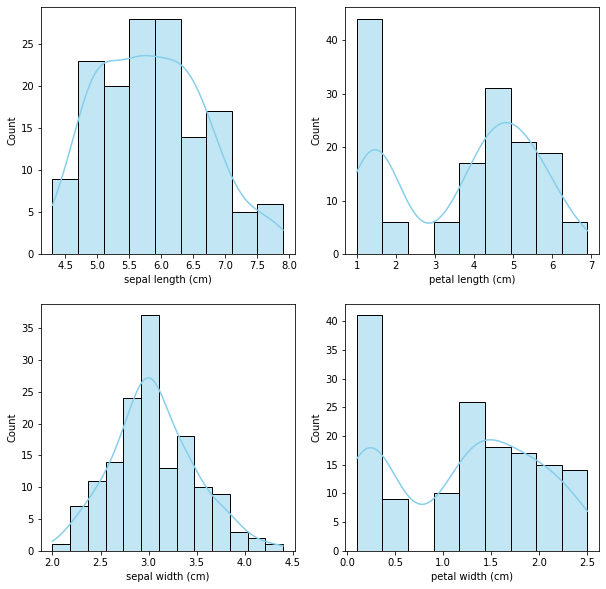

In [9]:
# Inspect normality
fig, axes = plt.subplots(2, 2, figsize = (10,10))
sns.histplot(iris_X.iloc[:,0], kde = True, color="skyblue", ax = axes[0,0])
sns.histplot(iris_X.iloc[:,1], kde = True, color="skyblue", ax = axes[1,0])
sns.histplot(iris_X.iloc[:,2], kde = True, color="skyblue", ax = axes[0,1])
sns.histplot(iris_X.iloc[:,3], kde = True, color="skyblue", ax = axes[1,1])


In [10]:
# Alternatively you can use normaltest from scipy
from scipy.stats import normaltest
normaltest(iris_X.iloc[:,0])

NormaltestResult(statistic=5.735584236235733, pvalue=0.05682424941067306)

Text(0.5, 1.0, 'petal width (cm)')

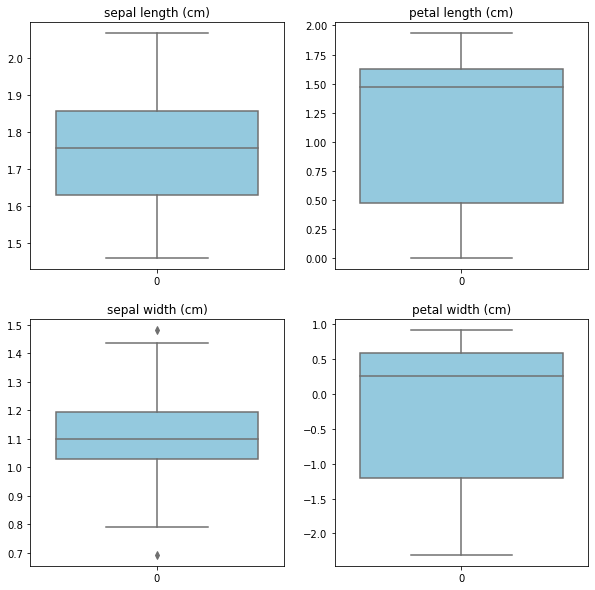

In [11]:
# Inspect equel variance
fig, axes = plt.subplots(2, 2, figsize = (10,10))
sns.boxplot(data=np.log(iris_X.iloc[:,0]), color="skyblue", ax = axes[0,0])
axes[0,0].set_title(iris_X.columns[0])
sns.boxplot(data=np.log(iris_X.iloc[:,1]), color="skyblue", ax = axes[1,0])
axes[1,0].set_title(iris_X.columns[1])
sns.boxplot(data=np.log(iris_X.iloc[:,2]), color="skyblue", ax = axes[0,1])
axes[0,1].set_title(iris_X.columns[2])
sns.boxplot(data=np.log(iris_X.iloc[:,3]), color="skyblue", ax = axes[1,1])
axes[1,1].set_title(iris_X.columns[3])

In [12]:
# Fit and assess the model
X_train, X_test, y_train, y_test = train_test_split(iris_X.iloc[:,2].values.reshape(-1,1), iris_y, test_size=0.2, random_state=0)
sklearn_lda = LDA()
sklearn_lda.fit(X_train, y_train)
print('Accuracy score', sklearn_lda.score(X_test, y_test))
print('Accuracy score', sklearn_lda.score(X_test, y_test))

Accuracy score 0.9666666666666667
Accuracy score 0.9666666666666667


## Intermezzo - Hyperparameter optimization

Most models, including support vector machines that will be covered in the next sections, have tunable hyperparameters. Hyperparameters are parameters whose values control the learning process and determine the values of model parameters that a learning algorithm ends up learning. In the case of the SVM the main hyperparameter is the regularization parameter (the lambda added before the norm in the regularization norm).  But the kernel itself can also be supplied as a hyperparameter. 

Two searches are often proposed to tune a machine learning model in function of its hyperparameters: 
- the first considers an exhaustive and structured search in the full hyperparameter space; 
- the second applies random combinations of hyperparameter settings. 

![grid](./grid_vs_randomgrid.png)

[It has been shown that when only few hyperparameters have an impact on model performance a randomized grid search is preferred. ](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) 

`Scikit-learn` offers implementations of [both](http://scikit-learn.org/stable/modules/grid_search.html) within a cross-validation scheme for hyperparameter tuning (see slide 36 of Lecture 2a on nested cross-validation).

![CV](./slide36.png)

## Support vector machines
<div class="alert alert-success">
EXERCISE: 
<ol>
<li> Choose one of the datasets down below to continue the exercise with
<li> Perform an 80/20 train-test split
<li> Define a hyperparameter dictionary with multiple values of the 'C' parameter in the SVC model and a linear and rbf kernel
<li> define the model (without the hyperparameters specified in the dictionary)
<li> Implement the GridSearchCV or the RandomSearchCV (or both 😉), fit the constructor and make predictions
<li> Look at the optimal hyperparameters selected and evaluate your predictions with the accuracy score metric
</ol>
</div>

In [13]:
# Dataset 1
from sklearn.datasets import make_circles
X_, y_= make_circles(n_samples=500, noise=0.06, random_state=42)
X_circle, y_circle = pd.DataFrame(X_), pd.DataFrame(y_)
X_circle.head()

,0,1
0,-0.750878,0.321070
1,-0.144829,0.990214
2,-0.765681,0.028995
3,-0.658622,-0.652663
4,-0.818977,0.612161


In [14]:
y_circle.head()

,0
0,1
1,0
2,1
3,0
4,0


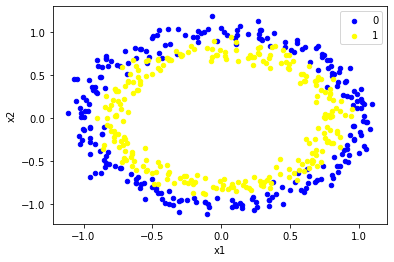

In [15]:
df = pd.DataFrame(dict(x1=X_[:, 0], x2=X_[:, 1], y=y_))
colors = {0:'blue', 1:'yellow'}
fig, ax = plt.subplots()
grouped = df.groupby('y')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color = colors[key])
plt.show()

In [16]:
from time import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

Starttime = time()
X_train, X_test, y_train, y_test = train_test_split(X_circle, y_circle, test_size=0.20, random_state=0)
parameters = {"C": np.logspace(-3,3,7), "kernel": ['linear', 'rbf']}
svc_rs = RandomizedSearchCV(SVC(), parameters)
svc_rs.fit(X_train, y_train.values.ravel())
pred = svc_rs.predict(X_test)
acc_rs = accuracy_score(y_test,pred)
Endtime = time()

print('Accuracy score on the circle dataset with RandomizedSearchCV', acc_rs)
print(Endtime-Starttime)
print(svc_rs.best_params_)

Accuracy score on the circle dataset with RandomizedSearchCV 0.91
0.896404504776001
{'kernel': 'rbf', 'C': 1.0}


In [17]:
from sklearn.model_selection import GridSearchCV
Starttime = time()
X_train, X_test, y_train, y_test = train_test_split(X_circle, y_circle, test_size=0.20, random_state=0)
parameters = {"C": np.logspace(-3,3,7), "kernel": ['linear', 'rbf']}
svc_gs = GridSearchCV(SVC(), parameters)
svc_gs.fit(X_train, y_train.values.ravel())
pred = svc_gs.predict(X_test)
acc_gs = accuracy_score(y_test,pred)
Endtime = time()

print('Accuracy score on the circle dataset with GridSearchCV', acc_rs)
print(Endtime-Starttime)
print(svc_rs.best_params_)

Accuracy score on the circle dataset with GridSearchCV 0.91
0.8583431243896484
{'kernel': 'rbf', 'C': 1.0}


Note that ```cv_results_```will give a lot more information on the GridSearchCV

In [18]:
# Dataset 2
from sklearn.datasets import load_breast_cancer
X_cancer, y_cancer= load_breast_cancer(return_X_y = True, as_frame = True)
X_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [19]:
np.unique(y_cancer) # the unique labels

array([0, 1])

In [20]:
Starttime = time()
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.20, random_state=0)
parameters = {"C": np.logspace(-3,3,7), "kernel": ['linear', 'rbf']}
svc_rs = RandomizedSearchCV(SVC(), parameters)
svc_rs.fit(X_train, y_train.values.ravel())
pred = svc_rs.predict(X_test)
acc_rs = accuracy_score(y_test,pred)
Endtime = time()

print('Accuracy score on the circle dataset with RandomizedSearchCV', acc_rs)
print(Endtime-Starttime)
print(svc_rs.best_params_)

Accuracy score on the circle dataset with RandomizedSearchCV 0.956140350877193
124.17092370986938
{'kernel': 'linear', 'C': 1.0}


In [21]:
from sklearn.model_selection import GridSearchCV
Starttime = time()
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.20, random_state=0)
parameters = {"C": np.logspace(-3,3,7), "kernel": ['linear', 'rbf']}
svc_gs = GridSearchCV(SVC(), parameters)
svc_gs.fit(X_train, y_train.values.ravel())
pred = svc_gs.predict(X_test)
acc_gs = accuracy_score(y_test,pred)
Endtime = time()

print('Accuracy score on the circle dataset with GridSearchCV', acc_rs)
print(Endtime-Starttime)
print(svc_rs.best_params_)

Accuracy score on the circle dataset with GridSearchCV 0.956140350877193
73.73982167243958
{'kernel': 'linear', 'C': 1.0}
